# Spotted!

AC215: Productionizing AI (MLOps)

Sunil Chomal, Alex Coward, Olga Leushina, Jonathan Sessa

## Model Training using WanDB

##**I. Environment Setup**

###I-1 Installs

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


###I-2 Imports

In [ ]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import random as rn
import numpy as np
from scipy import stats as st

# File and System Libraries
import os
import pickle
import pathlib
import time

# TensorFlow Libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras import backend as K

# SKLearn Dataset Management and Model Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger



###I-3 Verify setup

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.14.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Tue Oct 24 06:51:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W /  70W |    361MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### MOUNT DRIVE TO UPLOAD TF RECORDS ####

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# It's assumed that the tf records are mounted to /content/drive/MyDrive/transformed-1/processed

Mounted at /content/drive


#### UPLOADING OF TF RECORDS - VERSION 1 FROM THE LECTURE MATERIALS https://github.com/dlops-io/ml-workflow/blob/main/src/model-training/package/trainer/task.py ####

In [ ]:
# Create TF Datasets using TF records
def get_dataset_tfrecord(
    image_width=224, image_height=224, num_channels=3, batch_size=32
):
    # Read TF Records
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    # @tf.function
    def parse_tfrecord_example(example_proto):
        parsed_example = tf.io.parse_single_example(example_proto, feature_description)

        # Image
        # image = tf.image.decode_jpeg(parsed_example['image'])
        image = tf.io.decode_raw(parsed_example["image"], tf.uint8)
        image.set_shape([num_channels * image_height * image_width])
        image = tf.reshape(image, [image_height, image_width, num_channels])
        # Label
        label = tf.cast(parsed_example["label"], tf.int32)
        label = tf.one_hot(label, num_classes)

        return image, label

    # Normalize pixels
    def normalize(image, label):
        image = image / 255
        return image, label

    # Read the tfrecord files
    train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_folder+ "/train*")
    validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_folder + "/val*")

    #############
    # Train data
    #############
    train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
    train_data = train_data.map(
        parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE
    )
    train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.batch(batch_size)
    train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

    ##################
    # Validation data
    ##################
    validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
    validation_data = validation_data.map(
        parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_data = validation_data.map(
        normalize, num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_data = validation_data.batch(batch_size)
    validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_data, validation_data

In [ ]:
#import tensorflow as tf
raw_dataset = tf.data.TFRecordDataset("/content/drive/MyDrive/transformed-1/processed")
#raw_dataset = train_ds
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

FailedPreconditionError: ignored

#### UPLOADING OF TF RECORDS - VERSION 2 FROM KERAS  https://keras.io/examples/keras_recipes/creating_tfrecords/ ####

In [ ]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/content/drive/MyDrive/transformed-1/processed"

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = [224, 224]

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/train*")
VALID_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/val*")
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/test*")
#split_ind = int(0.9 * len(FILENAMES))
#TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

#TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 13
Validation TFRecord Files: 2
Test TFRecord Files: 2


In [ ]:
# Decode the data - function to convert images to tensors
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [ ]:
# Go through our TFRecords and parse out the image and the target values.
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

In [ ]:
# Try - this is where it fails;(
print(read_tfrecord(TRAINING_FILENAMES[1], labeled = True))

InvalidArgumentError: ignored

####I-4 Connect to Drive for saving of models during training and experimentation

Model training was performed using Google Colab, with the weights and history for each model saved so the notebook can be edited and shared without having to re-train the models.

In [ ]:
# When True: Load model weights and history from saved data
# When False: Train all models anew (in Google Colab)
# THIS CAN BE SKIPPED
USE_SAVED_MODEL = False

# Google Colab Specific Code for loading/saving models
if USE_SAVED_MODEL:
    from google.colab import drive

    drive.mount('/content/gdrive')
    path = "/content/gdrive/MyDrive/spotted_project"
    os.chdir(path)

    # Use GPU for model training
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

else:
    # Set working path to current directory
    path = "./"
    os.chdir(path)
    os.getcwd()

# Enable/Disable Eager Execution
tf.compat.v1.enable_eager_execution()

# Better performance with the tf.data API
AUTOTUNE = tf.data.AUTOTUNE

##**II. Dataset load and analysis**

###II-1 Load data into tf records

The Stanford Dogs dataset consists of 20,580 images of individual dogs classified among 120 different breeds.

In [ ]:
# Load data from TensorFlow Dataset
ds, ds_info = tfds.load("stanford_dogs",
                        split="train",
                        shuffle_files=True,
                        as_supervised=True,
                        with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXUYCX9/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteXUYCX9/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
tfrecords_folder = "/content/drive/MyDrive/transformed_data/processed"

In [ ]:
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_folder+ "/train*")

In [ ]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 63
num_classes = 120

In [ ]:
train_ds, val_ds = get_dataset_tfrecord(
    image_width=image_width,
    image_height=image_height,
    num_channels=num_channels,
    batch_size=batch_size,
)

In [ ]:
ds, ds_info =

In [ ]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [ ]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_ds = get_dataset(TRAINING_FILENAMES)

In [ ]:
val_ds = get_dataset(VALID_FILENAMES)

In [ ]:
image_batch, label_batch = next(iter(train_ds))

InvalidArgumentError: ignored

In [ ]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

image_batch, label_batch = next(iter(train_dataset))


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

InvalidArgumentError: ignored

###II-2 Exploratory Data Analysis

To better understand the images contained in the dataset and what preprocessing would be required, we examined the dimensionality of the images and checked for potential outliers.

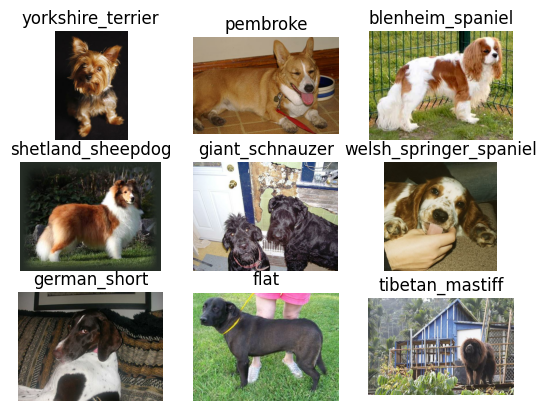

In [ ]:
# function to format labels (for Stanford dogs dataset)

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

# show examples (Stanford dog-specific with conversion of labels to nice format)
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

#### Image Dimensions

Each image in the dataset is of a different dog (or dogs) with different background information and orientations.

In [ ]:
# Determine the widths and heights for all images
ds_iter = iter(ds)

widths, heights = [], []
min_width, min_height = 500, 500
max_width, max_height = 0, 0

# Determine largest width and height
for data in ds_iter:
    img = data[0]

    widths.append(img.shape[0])
    min_width = min(min_width, img.shape[0])
    max_width = max(max_width, img.shape[0])

    heights.append(img.shape[1])
    min_height = min(min_height, img.shape[1])
    max_height = max(max_height, img.shape[1])

print(f'Minimum Width: {min_width}; Minimum Height: {min_height}')
print(f'Maximum Width: {max_width}; Maximum Height: {max_height}')

InvalidArgumentError: ignored

In [ ]:
NUM_CLASSES = ds_info.features["label"].num_classes

In [ ]:
# Determine most common width and height
widths = np.array(widths)
heights = np.array(heights)

w_mode = st.mode(widths, keepdims=False)[0]
h_mode = st.mode(heights, keepdims=False)[0]

print(f'Most Common Width: {w_mode}')
print(f'Most Common Height: {h_mode}')

Most Common Width: 375
Most Common Height: 500


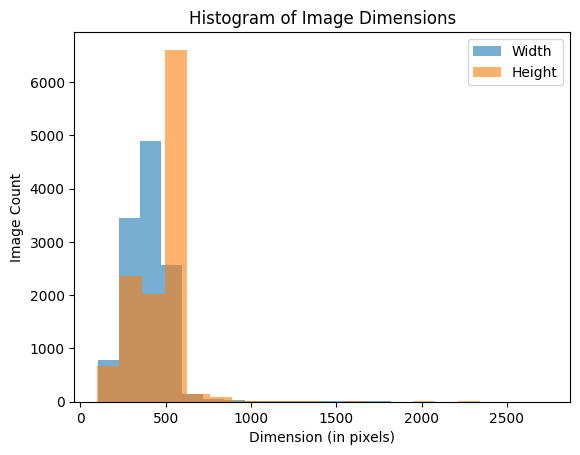

In [ ]:
# View distribution of image dimensions
plt.hist(widths, alpha=0.6, label='Width', bins=20)
plt.hist(heights, alpha=0.6, label='Height', bins=20)
plt.xlabel('Dimension (in pixels)')
plt.ylabel('Image Count')
plt.title('Histogram of Image Dimensions')
plt.legend();

The most common image dimensions are 375 pixels in width and 500 pixels in height. Depending on the model we choose, we will need to resize the images, but should use caution not to morph character features by changing the image aspect ratio.

###III-3 Data Preprocessing

#### Image Resizing and Padding

Due to differences in image sizes, we must resize our images so they all have the same dimension. However, we also want to preserve the aspect ratio so we do not warp animal features. As a result, we apply padding to the images after resizing.

In [ ]:
# Preprocess dataset to resize and normalize images
IMG_SIZE = 224
PAD_SIZE = 224
BATCH_SIZE = 64

# Resize image, pad to desired size, then normalize
def preprocess(image, label):
    # Resize image then pad to reach desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], preserve_aspect_ratio=True)
    shape = tf.shape(image)
    top_pad = (PAD_SIZE - shape[0]) // 2
    left_pad = (PAD_SIZE - shape[1]) // 2
    image = tf.image.pad_to_bounding_box(image, top_pad, left_pad, PAD_SIZE, PAD_SIZE)

    # Convert value to float (for pre-processing)
    image = tf.cast(image, tf.float32)

    # One-hot categorical encoding for labels
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

##**III. Data Split with preprocessing**

We are using a 70-15-15 split for our training, validation, and testing data. We apply our preprocessing function to each dataset, as well as cache, batch, and prefetch our training/validaiton data to speed up training.

In [ ]:
tfds.disable_progress_bar()

# Create a 70/15/15 train/validation/test split
train_ds, val_ds, test_ds = tfds.load('stanford_dogs',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True,
                                      as_supervised=True)

train_ds = (
    train_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

##**IV. Experiment tracking**

In [ ]:
# Login to W&B account
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

##**V. MODELS**

###V-0. Shared parameters for models below

In [ ]:
project_name = "spotted-full-data-run"

###V-1. EfficientNetV2

For this example, we chose to use EfficientNetV2 B0 as our base model. EfficientNetV2 has shown a high level of classification accuracy when compared to other models, but with a fraction of the parameters. The smaller size of EfficientNet also allows us to train faster (which allows for easier experimentation and hyperparameter tuning).

#### EfficientNetV2 Model preparation

In [ ]:
model_name = "EfficientNetV2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet V2 B0 from keras.applications
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels),
    include_preprocessing=False
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

We freeze the weights of the base model, and apply a Global Average Pooling layer to reduce the dimensionality of the model's output. We then use a dense layer with the same number of classes we are trying to predict and softmax activation to train the model to generate a prediction probability for each breed.

In [ ]:
# Change from 120 to see if model training will work - debug
NUM_CLASSES = 1

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "EfficientNetV2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                         

#### EfficientNetV2 Feature Extraction - train the top layer

In [ ]:
USE_SAVED_MODEL = False

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

EfficientNetV2_base_model_execution_time = execution_time

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: ignored

#### EfficientNetV2 Fine-Tuning

In [ ]:
model_name = "EfficientNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

EfficientNetV2_final_model_execution time = execution_time

#### EfficientNetV2 Prediction and testing accuracy

In [ ]:
from tensorflow.keras.utils import to_categorical
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Baseline Model accuracy
EfficientNetV2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"EfficientNetV2-based model testing accuracy (fine-tuned): {EfficientNetV2_testing_accuracy}")
print(f"Base model training time: {EfficientNetV2_base_model_execution_time}")
print(f"Final model training time: {EfficientNetV2_final_model_execution_time}")

EfficientNetV2-based model testing accuracy: 0.8266666666666667


###**V-2. XCeption**

####XCeption Model preparation

In [ ]:
model_name = "XCeption_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load XCeption from keras.applications
base_model = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

83683744/83683744 [==============================] - 8s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "XCeption_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)       

####XCeption Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.3484 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_205743-un4lx918/files/model-best)... Done. 13.4s


132/132 [==============================] - 92s 637ms/step - loss: 1.3484 - accuracy: 0.6562 - val_loss: 1.0598 - val_accuracy: 0.7311
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.8540

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_205743-un4lx918/files/model-best)... Done. 14.7s


132/132 [==============================] - 97s 737ms/step - loss: 0.4968 - accuracy: 0.8540 - val_loss: 0.8903 - val_accuracy: 0.7378
Epoch 3/10
132/132 [==============================] - 41s 310ms/step - loss: 0.2592 - accuracy: 0.9287 - val_loss: 0.9354 - val_accuracy: 0.7489
Epoch 4/10
132/132 [==============================] - 42s 313ms/step - loss: 0.1499 - accuracy: 0.9650 - val_loss: 0.9597 - val_accuracy: 0.7489
Epoch 5/10
132/132 [==============================] - 42s 317ms/step - loss: 0.0956 - accuracy: 0.9826 - val_loss: 0.9691 - val_accuracy: 0.7539
Epoch 6/10
132/132 [==============================] - 42s 317ms/step - loss: 0.0664 - accuracy: 0.9894 - val_loss: 0.9838 - val_accuracy: 0.7606
Epoch 7/10
132/132 [==============================] - 42s 314ms/step - loss: 0.0495 - accuracy: 0.9932 - val_loss: 1.0046 - val_accuracy: 0.7578
Epoch 8/10
132/132 [==============================] - 41s 311ms/step - loss: 0.0392 - accuracy: 0.9950 - val_loss: 1.0280 - val_accuracy: 0.7

accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆█▇▇▇█
val_loss,█▁▃▄▄▅▆▇▇█
accuracy,0.99738
best_epoch,1
best_val_loss,0.89033
epoch,9
loss,0.02722
val_accuracy,0.76056


####XCeption Fine-Tuning

In [ ]:
model_name = "Xception_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_final_model_execution_time = execution_time

Model: "XCeption_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)       

132/132 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9962

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_210935-eypn9jih/files/model-best)... Done. 24.0s


132/132 [==============================] - 256s 2s/step - loss: 0.0260 - accuracy: 0.9962 - val_loss: 1.0410 - val_accuracy: 0.7594
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_210935-eypn9jih/files/model-best)... Done. 20.3s


132/132 [==============================] - 206s 2s/step - loss: 0.0146 - accuracy: 0.9976 - val_loss: 1.0323 - val_accuracy: 0.7667
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9985

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_210935-eypn9jih/files/model-best)... Done. 20.6s


132/132 [==============================] - 219s 2s/step - loss: 0.0095 - accuracy: 0.9985 - val_loss: 1.0122 - val_accuracy: 0.7667
Epoch 4/10
132/132 [==============================] - 131s 990ms/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 1.0131 - val_accuracy: 0.7667
Epoch 5/10
132/132 [==============================] - 131s 991ms/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 1.0159 - val_accuracy: 0.7706
Epoch 6/10
 82/132 [=================>............] - ETA: 47s - loss: 0.0036 - accuracy: 1.0000

#### XCeption Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Baseline Model accuracy
XCeption_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"XCeption-based model testing accuracy: {XCeption_testing_accuracy}")
print(f"Base model training time: {XCeption_base_model_execution_time}")
print(f"Final model training time: {XCeption_final_model_execution_time}")

###**V-3. ResNet50V2**

####ResNet50V2 Model preparation

In [ ]:
model_name = "ResNet50V2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load ResNet50V2 from keras.applications
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "ResNet50V2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)     

####ResNet50V2 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - 44s 272ms/step - loss: 2.0003 - accuracy: 0.5027 - val_loss: 1.2699 - val_accuracy: 0.6567
Epoch 2/10
132/132 [==============================] - 28s 215ms/step - loss: 0.5913 - accuracy: 0.8433 - val_loss: 1.1969 - val_accuracy: 0.6694
Epoch 3/10
132/132 [==============================] - 30s 224ms/step - loss: 0.2707 - accuracy: 0.9490 - val_loss: 1.2149 - val_accuracy: 0.6706
Epoch 4/10
132/132 [==============================] - 28s 213ms/step - loss: 0.1364 - accuracy: 0.9845 - val_loss: 1.2304 - val_accuracy: 0.6767
Epoch 5/10
132/132 [==============================] - 30s 228ms/step - loss: 0.0809 - accuracy: 0.9951 - val_loss: 1.2479 - val_accuracy: 0.6783
Epoch 6/10
132/132 [==============================] - 29s 220ms/step - loss: 0.0554 - accuracy: 0.9974 - val_loss: 1.2671 - val_accuracy: 0.6833
Epoch 7/10
132/132 [==============================] - 29s 216ms/step - loss: 0.0411 - accuracy: 0.9981 - val_loss: 1.2845 - val_ac

####ResNet50V2 Fine-Tuning

In [ ]:
model_name = "ResNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_final_model_execution_time = execution_time

Model: "ResNet50V2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)     

#### ResNet50V2 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Model accuracy and training time summary
ResNet50V2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"ResNet50V2 testing accuracy: {ResNet50V2_testing_accuracy}")
print(f"Base model training time: {ResNet50V2_base_model_execution_time}")
print(f"Final model training time: {ResNet50V2_final_model_execution_time}")

###**V-4. VGG16**

####VGG16 Model preparation

In [ ]:
model_name = "VGG16_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet VGG16 from keras.applications
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "VGG16_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)          

####VGG16 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - 64s 357ms/step - loss: 4.1288 - accuracy: 0.1093 - val_loss: 4.2828 - val_accuracy: 0.1172
Epoch 2/10
132/132 [==============================] - 45s 341ms/step - loss: 2.6913 - accuracy: 0.3639 - val_loss: 3.4990 - val_accuracy: 0.2861
Epoch 3/10
132/132 [==============================] - 45s 344ms/step - loss: 2.0848 - accuracy: 0.5018 - val_loss: 2.8006 - val_accuracy: 0.3617
Epoch 4/10
132/132 [==============================] - 45s 344ms/step - loss: 1.7203 - accuracy: 0.5896 - val_loss: 2.4315 - val_accuracy: 0.3922
Epoch 5/10
132/132 [==============================] - 45s 342ms/step - loss: 1.4639 - accuracy: 0.6524 - val_loss: 2.3032 - val_accuracy: 0.4089
Epoch 6/10
132/132 [==============================] - 42s 321ms/step - loss: 1.2667 - accuracy: 0.7025 - val_loss: 2.2665 - val_accuracy: 0.4144
Epoch 7/10
132/132 [==============================] - 42s 318ms/step - loss: 1.1066 - accuracy: 0.7477 - val_loss: 2.2581 - val_ac

####VGG16 Fine-tuning

In [ ]:
model_name = "VGG16_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Free up memory
K.clear_session()

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)
# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, validation_data = val_ds, callbacks=[WandbCallback()]
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_final_model_execution_time = execution_time

Model: "VGG16_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)          

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
  6/132 [>.............................] - ETA: 1:32 - loss: 0.6029 - accuracy: 0.8958

132/132 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.8838

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 1.5s


132/132 [==============================] - 143s 908ms/step - loss: 0.5515 - accuracy: 0.8838 - val_loss: 2.1170 - val_accuracy: 0.4794
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.9594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 5.9s


132/132 [==============================] - 122s 922ms/step - loss: 0.3114 - accuracy: 0.9594 - val_loss: 2.0527 - val_accuracy: 0.4989
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9887

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 0.9s


132/132 [==============================] - 119s 903ms/step - loss: 0.1954 - accuracy: 0.9887 - val_loss: 2.0240 - val_accuracy: 0.5017
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9952

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 0.8s


132/132 [==============================] - 120s 908ms/step - loss: 0.1305 - accuracy: 0.9952 - val_loss: 2.0160 - val_accuracy: 0.5017
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 1.8s


132/132 [==============================] - 126s 958ms/step - loss: 0.0934 - accuracy: 0.9982 - val_loss: 2.0059 - val_accuracy: 0.5022
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 4.1s


132/132 [==============================] - 125s 947ms/step - loss: 0.0712 - accuracy: 0.9982 - val_loss: 1.9930 - val_accuracy: 0.5106
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9983

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 1.0s


132/132 [==============================] - 125s 945ms/step - loss: 0.0567 - accuracy: 0.9983 - val_loss: 1.9809 - val_accuracy: 0.5056
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9983

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 9.6s


132/132 [==============================] - 134s 1s/step - loss: 0.0464 - accuracy: 0.9983 - val_loss: 1.9631 - val_accuracy: 0.5167
Epoch 9/10
132/132 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9986

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 7.7s


132/132 [==============================] - 132s 1s/step - loss: 0.0385 - accuracy: 0.9986 - val_loss: 1.9562 - val_accuracy: 0.5161
Epoch 10/10
132/132 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9998

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231005_190158-6kjlk1mx/files/model-best)... Done. 8.1s


132/132 [==============================] - 139s 1s/step - loss: 0.0322 - accuracy: 0.9998 - val_loss: 1.9554 - val_accuracy: 0.5172
Training execution time (mins) 23.158390851815543


accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▅▅▇▆███
val_loss,█▅▄▄▃▃▂▁▁▁
accuracy,0.99976
best_epoch,9
best_val_loss,1.9554
epoch,9
loss,0.03222
val_accuracy,0.51722


#### VGG16 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
# Model accuracy and training time summary
VGG16_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"VGG16 testing accuracy: {VGG16_testing_accuracy}")
print(f"Base model training time: {VGG16_base_model_execution_time}")
print(f"Final model training time: {VGG16_final_model_execution_time}")

##**VI. SUMMARY OF MODELS**

In [ ]:
print ("1. EfficientNetV2 transfer learning --------------")
print(f"EfficientNetV2-based model testing accuracy: {EfficientNetV2_testing_accuracy}")
print(f"Base model training time: {EfficientNetV2_base_model_execution_time}")
print(f"Final model training time: {EfficientNetV2_model_execution_time}")
print ("2. XCeption transfer learning --------------")
print(f"XCeption-based model testing accuracy: {XCeption_testing_accuracy}")
print(f"Base model training time: {XCeption_base_model_execution_time}")
print(f"Final model training time: {XCeption_model_execution_time}")
print ("ResNet50V2 transfer learning --------------")
print(f"ResNet50V2 testing accuracy: {ResNet50V2_testing_accuracy}")
print(f"Base model training time: {ResNet50V2_base_model_execution_time}")
print(f"Final model training time: {ResNet50V2_model_execution_time}")
print ("VGG16 transfer learning --------------")
print(f"VGG16 testing accuracy: {VGG16_testing_accuracy}")
print(f"Base model training time: {VGG16_base_model_execution_time}")
print(f"Final model training time: {VGG16_model_execution_time}")

##**VII. Download Model from WandB CODE**

####W&B Usage API

In [ ]:
run = wandb.init()
artifact = run.use_artifact('spotted-dog/Stanford-dogs%20breeds/model-VGG16_fine-tune', type='model')
artifact_dir = artifact.download()

In [ ]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

##**We don't run this part anymore since we use wandb

In [ ]:
# Helper function for plotting training history
# Adapted from CS109B: Lab 8 Notebook

def plot_history(model_history, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(model_history['loss'], label='train')
    axs[0].plot(model_history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    best_loss = np.nanmin(model_history['val_loss'])
    axs[0].axvline(np.nanargmin(model_history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title('Loss')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model_history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model_history[cur_history])
            else:
                train_accuracy.append(model_history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title('Accuracy')
    plt.suptitle(title)

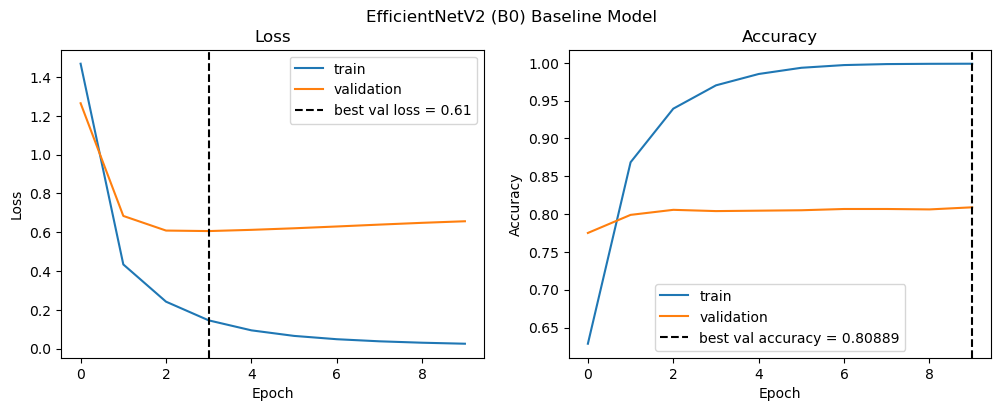

In [ ]:
# Plot the history of model training
plot_history(baseline_model_history, title = 'EfficientNetV2 (B0) Baseline Model')

After the first few epochs, validation accuraccy levels off. This can likely be attributed to not having any data augmentation and the model quickly learning all it can from the training data. Given the complexity of the problem, an accuracy of about 80% sounds good and shows that EfficientNet is likely a good baseline model to use and work from.

### Baseline Model Evaluation

After training the baseline model, we want to understands its accuracy when making predictions on the test dataset:

In [ ]:
# Get model predictions on test set
y_pred = baseline_model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 16s 557ms/step


In [ ]:
# Baseline Model accuracy
print(f"Model testing accuracy: {accuracy_score(y_true, y_pred)}")

Model testing accuracy: 0.81


## Next Steps

To improve our model performance, we will include additional data as well as data augmentation using random transformations to increase the variety of training images.

We will also explore other potential models, as well as do additional training and fine-tuning on the selected model.